Starting Q-SOFUL Experiment: d=50, s*=5, Q_total=1e+05
Epoch 5: Queries=2.3e+03, CumRegret=398.92, Gap=0.0397, Beta=2146.3738
Epoch 10: Queries=1.8e+04, CumRegret=9268.21, Gap=0.8869, Beta=399.2560
Epoch 15: Queries=1.1e+05, CumRegret=66839.60, Gap=0.8183, Beta=72.5510


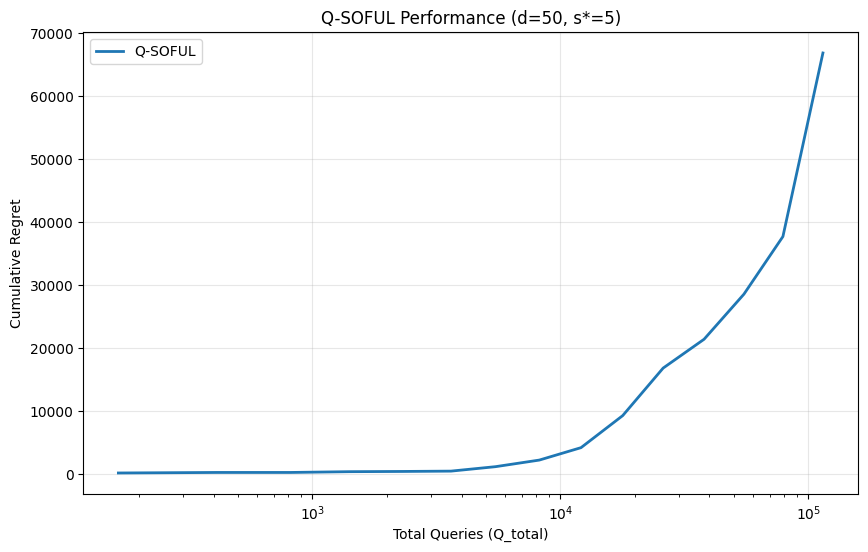

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from environment import LinearBanditEnv, SimulatedQuantumOracle
from oracles import StatisticalAEOracle
from agent import QSOFULAgent

def run_experiment(d=20, s_star=3, Q_total=1e6, seed=42):
    # 1. Setup
    # Use distinct seeds for Env and Agent
    rng_env = np.random.default_rng(seed)
    rng_agent = np.random.default_rng(seed + 1)
    
    # Initialize Oracle & Environment
    # We use StatisticalAEOracle for physics-faithful simulation
    oracle = StatisticalAEOracle(rng=rng_env)
    env = LinearBanditEnv(d=d, s_star=s_star, oracle=oracle, random_seed=seed)
    
    # Initialize Agent
    agent = QSOFULAgent(d=d, s_star=s_star, delta_tot=0.01, Q_total=Q_total, seed=seed+1)
    
    # Logging
    total_queries = 0
    cumulative_regret = 0.0
    logs = {'queries': [], 'regret': [], 'epoch': []}
    
    print(f"Starting Q-SOFUL Experiment: d={d}, s*={s_star}, Q_total={Q_total:.0e}")
    
    # 2. Main Loop
    while total_queries < Q_total:
        # A. Schedule (Get eps, delta for this epoch)
        eps_k, delta_k, _ = agent.prepare_epoch()
        
        # B. Select Action (Smoothed OFU)
        x_base, x_played = agent.select_action()
        
        # C. Query Environment
        try:
            y_hat, cost = env.get_reward_query(x_played, eps_k, delta_k)
        except ValueError as e:
            print(f"Error in query: {e}")
            break
            
        # D. Update Agent (Weighted Lasso)
        agent.update_model(x_played, y_hat)
        
        # E. Calculate Regret (Eq 5)
        # Regret is calculated using the BASE action x_base (per Remark 1 in paper)
        # or x_played? Eq 5 uses tilde_x_k (played).
        # However, Remark 1 says Expected Regret coincides with base.
        # Let's stick to Eq 5 definition: R = sum n_k * (opt - played)
        # Note: Since x_played has zero-mean noise added to x_base, 
        # the term E[x_played] = x_base. 
        # We calculate the *Realized* regret here.
        
        # Optimal Reward
        # We need access to theta_star to calculate regret (Simulation privilege)
        opt_val = np.linalg.norm(env.theta_star, 1) # Since opt action aligns with signs
        # Actually, max_x x^T theta for box constraint is ||theta||_1
        
        actual_val = env.true_reward(x_played)
        instant_gap = opt_val - actual_val
        
        epoch_regret = cost * instant_gap
        cumulative_regret += epoch_regret
        total_queries += cost
        
        # Logging
        logs['queries'].append(total_queries)
        logs['regret'].append(cumulative_regret)
        logs['epoch'].append(agent.k)
        
        if agent.k % 5 == 0:
            print(f"Epoch {agent.k}: Queries={total_queries:.1e}, "
                  f"CumRegret={cumulative_regret:.2f}, "
                  f"Gap={instant_gap:.4f}, Beta={agent.beta_k:.4f}")

    return logs

if __name__ == "__main__":
    # Run a quick demonstration
    data = run_experiment(d=50, s_star=5, Q_total=1e5)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(data['queries'], data['regret'], label='Q-SOFUL', linewidth=2)
    plt.xlabel('Total Queries (Q_total)')
    plt.ylabel('Cumulative Regret')
    plt.title('Q-SOFUL Performance (d=50, s*=5)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xscale('log') # Log scale to see the epochs clearly
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from environment import LinearBanditEnv
from oracles import StatisticalAEOracle
from agent import QSOFULAgent

# --- Helper Wrapper to Run a Single Experiment ---
def run_single_trial(d, s_star, Q_total, seed):
    """
    Runs one instance of Q-SOFUL and returns the final cumulative regret
    and the full trace for plotting.
    """
    rng_env = np.random.default_rng(seed)
    # Use StatisticalAEOracle for physics-faithful simulation
    oracle = StatisticalAEOracle(rng=rng_env)
    env = LinearBanditEnv(d=d, s_star=s_star, oracle=oracle, random_seed=seed)
    agent = QSOFULAgent(d=d, s_star=s_star, delta_tot=0.01, Q_total=Q_total, seed=seed+1)
    
    total_queries = 0
    cumulative_regret = 0.0
    trace_queries = []
    trace_regret = []
    
    while total_queries < Q_total:
        eps_k, delta_k, _ = agent.prepare_epoch()
        x_base, x_played = agent.select_action()
        
        try:
            y_hat, cost = env.get_reward_query(x_played, eps_k, delta_k)
        except ValueError:
            break
            
        agent.update_model(x_played, y_hat)
        
        # Calculate Regret
        # Theoretical optimal is ||theta*||_1 approx 1.0
        # Instant regret = (opt - true_reward(x_played))
        val_opt = np.linalg.norm(env.theta_star, 1)
        val_played = env.true_reward(x_played)
        
        # Clamp gap to be non-negative (numerical noise can make it slightly negative)
        gap = max(0.0, val_opt - val_played)
        
        epoch_regret = cost * gap
        cumulative_regret += epoch_regret
        total_queries += cost
        
        trace_queries.append(total_queries)
        trace_regret.append(cumulative_regret)
        
    return cumulative_regret, trace_queries, trace_regret

# --- Experiment 1: Dimension Scaling ---
def run_dimension_sweep():
    print("\n--- Running Experiment 1: Dimension Scaling (d) ---")
    s_star_fixed = 3
    Q_fixed = 2e5  # Reduced slightly for speed
    d_values = [20, 50, 100, 200, 500]
    final_regrets = []
    
    for d in d_values:
        print(f"Testing d={d}...")
        # Run 3 seeds and average to reduce noise
        seeds = [42, 43, 44]
        regrets = []
        for s in seeds:
            final_r, _, _ = run_single_trial(d, s_star_fixed, Q_fixed, s)
            regrets.append(final_r)
        final_regrets.append(np.mean(regrets))
        
    return d_values, final_regrets

# --- Experiment 2: Sparsity Scaling ---
def run_sparsity_sweep():
    print("\n--- Running Experiment 2: Sparsity Scaling (s*) ---")
    d_fixed = 100
    Q_fixed = 2e5
    s_values = [1, 3, 5, 8, 10]
    final_regrets = []
    
    for s_star in s_values:
        print(f"Testing s*={s_star}...")
        seeds = [101, 102, 103]
        regrets = []
        for s in seeds:
            final_r, _, _ = run_single_trial(d_fixed, s_star, Q_fixed, s)
            regrets.append(final_r)
        final_regrets.append(np.mean(regrets))
        
    return s_values, final_regrets

# --- Experiment 3: Trace Comparison ---
def run_trace_comparison():
    print("\n--- Running Experiment 3: Visual Trace Comparison ---")
    s_star = 3
    Q_total = 5e5
    
    # Compare d=50 vs d=500
    print("Running trace for d=50...")
    _, q50, r50 = run_single_trial(d=50, s_star=s_star, Q_total=Q_total, seed=500)
    
    print("Running trace for d=500...")
    _, q500, r500 = run_single_trial(d=500, s_star=s_star, Q_total=Q_total, seed=500)
    
    return (q50, r50), (q500, r500)

# --- Master Plotter ---
if __name__ == "__main__":
    # 1. Run Sweeps
    d_data = run_dimension_sweep()
    s_data = run_sparsity_sweep()
    trace_data_50, trace_data_500 = run_trace_comparison()
    
    # 2. Create Plot Grid
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot A: Dimension Scaling
    d_vals, d_regrets = d_data
    axs[0].plot(d_vals, d_regrets, 'o-', linewidth=2, color='navy')
    axs[0].set_title(f'Dimension Dependence (s*=3)\nTarget: ~sqrt(log d)', fontsize=12)
    axs[0].set_xlabel('Dimension (d)')
    axs[0].set_ylabel('Final Cumulative Regret')
    axs[0].grid(True, alpha=0.3)
    
    # Plot B: Sparsity Scaling
    s_vals, s_regrets = s_data
    axs[1].plot(s_vals, s_regrets, 's-', linewidth=2, color='darkgreen')
    axs[1].set_title(f'Sparsity Dependence (d=100)\nTarget: ~Linear in s*', fontsize=12)
    axs[1].set_xlabel('Sparsity (s*)')
    axs[1].grid(True, alpha=0.3)
    
    # Plot C: Traces
    axs[2].plot(trace_data_50[0], trace_data_50[1], label='d=50', linewidth=2)
    axs[2].plot(trace_data_500[0], trace_data_500[1], label='d=500', linewidth=2, linestyle='--')
    axs[2].set_title('Regret Traces: Small vs Large Dim', fontsize=12)
    axs[2].set_xlabel('Total Queries')
    axs[2].set_xscale('log')
    axs[2].legend()
    axs[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    print("Done! Check the plots to verify Q-SOFUL scaling properties.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
from environment import LinearBanditEnv
from oracles import StatisticalAEOracle
from agent import QSOFULAgent

# --- Configuration ---
N_CORES = -1      # Use all available CPU cores
N_TRIALS = 30     # High number of trials to smooth out the "zig-zag" noise
Q_TOTAL = 1e5     # Horizon for sweeps
SEED_OFFSET = 1000

# --- Core Runner (Same as before) ---
def run_single_trial(d, s_star, Q_total, seed):
    """
    Runs one instance of Q-SOFUL.
    """
    rng_env = np.random.default_rng(seed)
    oracle = StatisticalAEOracle(rng=rng_env)
    env = LinearBanditEnv(d=d, s_star=s_star, oracle=oracle, random_seed=seed)
    # Different seed for agent to avoid correlation
    agent = QSOFULAgent(d=d, s_star=s_star, delta_tot=0.01, Q_total=Q_total, seed=seed+999)
    
    total_queries = 0
    cumulative_regret = 0.0
    
    while total_queries < Q_total:
        eps_k, delta_k, _ = agent.prepare_epoch()
        x_base, x_played = agent.select_action()
        
        try:
            y_hat, cost = env.get_reward_query(x_played, eps_k, delta_k)
        except ValueError:
            break
            
        agent.update_model(x_played, y_hat)
        
        # Regret Calculation
        val_opt = np.linalg.norm(env.theta_star, 1)
        val_played = env.true_reward(x_played)
        epoch_regret = cost * max(0.0, val_opt - val_played)
        
        cumulative_regret += epoch_regret
        total_queries += cost
        
    return cumulative_regret

# --- Parallel Helper ---
def run_point_parallel(d, s_star, Q_total, n_trials):
    """
    Runs N_TRIALS in parallel for a specific (d, s*) configuration.
    Returns mean and std of final regret.
    """
    seeds = [SEED_OFFSET + i for i in range(n_trials)]
    
    # Execute in parallel
    results = Parallel(n_jobs=N_CORES)(
        delayed(run_single_trial)(d, s_star, Q_total, seed) for seed in seeds
    )
    
    return np.mean(results), np.std(results)

# --- Sweep 1: Fine-Grained Dimension Grid ---
def run_fine_dim_sweep():
    print(f"\n--- 1. Massive Dimension Sweep (Trials={N_TRIALS}) ---")
    s_star = 3
    # Log-spaced grid to capture the log(d) behavior nicely
    # 20, 30, 50, 80, 130, 200, 300, 500, 800, 1000
    d_values = np.unique(np.logspace(np.log10(20), np.log10(1000), num=12).astype(int))
    
    means = []
    stds = []
    
    for d in d_values:
        start = time.time()
        mu, sigma = run_point_parallel(d, s_star, Q_TOTAL, N_TRIALS)
        means.append(mu)
        stds.append(sigma)
        print(f"  d={d:4d} | Regret={mu:.0f} ± {sigma:.0f} | Time={time.time()-start:.1f}s")
        
    return d_values, np.array(means), np.array(stds)

# --- Sweep 2: Fine-Grained Sparsity Grid ---
def run_fine_sparsity_sweep():
    print(f"\n--- 2. Massive Sparsity Sweep (Trials={N_TRIALS}) ---")
    d = 200
    # Linear grid 1 to 15
    s_values = np.arange(1, 30, 2) 
    
    means = []
    stds = []
    
    for s_star in s_values:
        start = time.time()
        mu, sigma = run_point_parallel(d, s_star, Q_TOTAL, N_TRIALS)
        means.append(mu)
        stds.append(sigma)
        print(f"  s*={s_star:2d} | Regret={mu:.0f} ± {sigma:.0f} | Time={time.time()-start:.1f}s")
        
    return s_values, np.array(means), np.array(stds)

# --- Plotting ---
def plot_results(dim_data, sparse_data):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Dimension
    d_vals, d_mean, d_std = dim_data
    axs[0].plot(d_vals, d_mean, 'o-', color='navy', linewidth=2, label='Mean Regret')
    axs[0].fill_between(d_vals, d_mean - d_std, d_mean + d_std, color='navy', alpha=0.15, label='±1 Std Dev')
    
    # Theoretical curve overlay: A * sqrt(log d) + B
    # Fit strictly to show scaling shape
    log_d = np.sqrt(np.log(d_vals))
    # Simple least squares fit
    A = np.polyfit(log_d, d_mean, 1)[0]
    B = np.polyfit(log_d, d_mean, 1)[1]
    axs[0].plot(d_vals, A * log_d + B, 'r--', linewidth=2, label=r'Fit: $\propto \sqrt{\log d}$')
    
    axs[0].set_title(f'Dimension Independence Test (Trials={N_TRIALS})', fontsize=14)
    axs[0].set_xlabel('Dimension $d$ (Log Scale)', fontsize=12)
    axs[0].set_ylabel('Cumulative Regret', fontsize=12)
    axs[0].set_xscale('log')
    axs[0].grid(True, which="both", ls="-", alpha=0.2)
    axs[0].legend()
    
    # Plot 2: Sparsity
    s_vals, s_mean, s_std = sparse_data
    axs[1].plot(s_vals, s_mean, 's-', color='darkgreen', linewidth=2, label='Mean Regret')
    axs[1].fill_between(s_vals, s_mean - s_std, s_mean + s_std, color='darkgreen', alpha=0.15, label='±1 Std Dev')
    
    # Theoretical curve: Linear
    A_s = np.polyfit(s_vals, s_mean, 1)[0]
    B_s = np.polyfit(s_vals, s_mean, 1)[1]
    axs[1].plot(s_vals, A_s * s_vals + B_s, 'r--', linewidth=2, label=r'Fit: $\propto s^*$')
    
    axs[1].set_title(f'Sparsity Dependence Test (d=200)', fontsize=14)
    axs[1].set_xlabel('Sparsity $s^*$', fontsize=12)
    axs[1].grid(True, alpha=0.3)
    axs[1].legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    d_data = run_fine_dim_sweep()
    s_data = run_fine_sparsity_sweep()
    plot_results(d_data, s_data)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
from copy import deepcopy

# Import your classes (assuming they are in the notebook or file)
from environment import LinearBanditEnv, QuantumOracle
from oracles import StatisticalAEOracle
from agent import QSOFULAgent

# --- Extended Oracle for Experiment 3 (Classical Baseline) ---
class ClassicalOracle(StatisticalAEOracle):
    """
    Simulates a Classical Monte Carlo estimator.
    Cost scales as O(1/epsilon^2) instead of O(1/epsilon).
    """
    def query(self, true_mean: float, epsilon: float, delta: float) -> tuple[float, int]:
        # Get the quantum estimate (for the value)
        val, _ = super().query(true_mean, epsilon, delta)
        
        # Overwrite the cost to reflect Classical Monte Carlo scaling
        # Classical samples needed ~ Var / epsilon^2. Var <= 1.
        # We assume similar constants for fair comparison.
        # Cost = C * (1/eps^2) * log(1/delta)
        k_trials = int(np.ceil(2.0 * np.log(1.0 / delta)))
        samples_per_trial = int(np.ceil(1.0 / (epsilon**2)))
        
        classical_cost = k_trials * samples_per_trial
        return val, classical_cost

# --- Core Runner with Detailed Telemetry ---
def run_detailed_trial(config):
    """
    Runs a trial and returns detailed telemetry (errors, regret, etc.)
    """
    d = config['d']
    s_star = config['s_star']
    Q_total = config['Q_total']
    sigma_p = config.get('sigma_p', 0.5)
    oracle_type = config.get('oracle_type', 'quantum')
    seed = config['seed']
    
    rng_env = np.random.default_rng(seed)
    
    # Select Oracle
    if oracle_type == 'classical':
        oracle = ClassicalOracle(rng=rng_env)
    else:
        oracle = StatisticalAEOracle(rng=rng_env)
        
    env = LinearBanditEnv(d=d, s_star=s_star, oracle=oracle, random_seed=seed)
    
    # Initialize Agent with custom sigma_p
    agent = QSOFULAgent(d=d, s_star=s_star, delta_tot=0.01, Q_total=Q_total, seed=seed+999)
    agent.sigma_p = sigma_p # Override perturbation
    
    # Telemetry
    history = {
        'queries': [],
        'regret': [],
        'l1_error': [],
        'l2_error': []
    }
    
    total_queries = 0
    cum_regret = 0.0
    
    while total_queries < Q_total:
        eps_k, delta_k, _ = agent.prepare_epoch()
        x_base, x_played = agent.select_action()
        
        try:
            y_hat, cost = env.get_reward_query(x_played, eps_k, delta_k)
        except ValueError:
            break
            
        agent.update_model(x_played, y_hat)
        
        # Calculate Metrics
        val_opt = np.linalg.norm(env.theta_star, 1)
        val_played = env.true_reward(x_played)
        epoch_regret = cost * max(0.0, val_opt - val_played)
        cum_regret += epoch_regret
        total_queries += cost
        
        # Estimation Error
        diff = agent.hat_theta - env.theta_star
        l1_err = np.linalg.norm(diff, 1)
        l2_err = np.linalg.norm(diff, 2)
        
        history['queries'].append(total_queries)
        history['regret'].append(cum_regret)
        history['l1_error'].append(l1_err)
        history['l2_error'].append(l2_err)
        
    return history

# --- Experiment 1: Convergence Rates (Lemma 1 Verification) ---
def run_convergence_experiment(n_trials=10):
    print("Running Exp 1: Estimation Error Convergence...")
    config = {'d': 200, 's_star': 5, 'Q_total': 1e6, 'sigma_p': 0.5, 'oracle_type': 'quantum'}
    
    seeds = range(1000, 1000 + n_trials)
    results = Parallel(n_jobs=-1)(
        delayed(run_detailed_trial)({**config, 'seed': s}) for s in seeds
    )
    
    # Interpolate results to common query grid for averaging
    query_grid = np.geomspace(100, 1e6, 100)
    l1_avg = np.zeros_like(query_grid)
    l2_avg = np.zeros_like(query_grid)
    
    for res in results:
        l1_avg += np.interp(query_grid, res['queries'], res['l1_error']) / n_trials
        l2_avg += np.interp(query_grid, res['queries'], res['l2_error']) / n_trials
        
    plt.figure(figsize=(8, 5))
    plt.loglog(query_grid, l1_avg, label=r'$L_1$ Error $\|\hat{\theta} - \theta^*\|_1$', lw=2)
    plt.loglog(query_grid, l2_avg, label=r'$L_2$ Error $\|\hat{\theta} - \theta^*\|_2$', lw=2)
    
    # Theoretical Slope: 1/sqrt(Q) for L2?
    # Actually Q_total ~ sqrt(W) -> W ~ Q^2. Error ~ 1/sqrt(W) ~ 1/Q. 
    # Let's plot 1/x reference
    ref_x = query_grid[20:] 
    plt.loglog(ref_x, 100 * ref_x**(-1.0), 'k--', alpha=0.5, label='Theory $\propto Q^{-1}$')
    
    plt.xlabel('Total Queries')
    plt.ylabel('Estimation Error')
    plt.title('Validation of Lemma 1: Error Convergence')
    plt.grid(True, which="both", alpha=0.2)
    plt.legend()
    plt.show()

# --- Experiment 2: The "Smoothing" Sweet Spot ---
def run_smoothing_sweep(n_trials=20):
    print("Running Exp 2: Smoothing Parameter Sweep...")
    sigmas = [0.0, 0.05, 0.2, 0.5, 1.0, 2.0]
    d = 100
    s_star = 3
    Q_total = 1e5
    
    final_regrets = []
    std_regrets = []
    
    for sig in sigmas:
        config = {'d': d, 's_star': s_star, 'Q_total': Q_total, 'sigma_p': sig, 'oracle_type': 'quantum'}
        seeds = range(2000, 2000 + n_trials)
        
        trial_results = Parallel(n_jobs=-1)(
            delayed(run_detailed_trial)({**config, 'seed': s}) for s in seeds
        )
        finals = [res['regret'][-1] for res in trial_results]
        final_regrets.append(np.mean(finals))
        std_regrets.append(np.std(finals))
        
    plt.figure(figsize=(8, 5))
    plt.errorbar(sigmas, final_regrets, yerr=std_regrets, fmt='o-', capsize=5, lw=2, color='purple')
    plt.xlabel(r'Perturbation Scale $\sigma_p$')
    plt.ylabel(f'Cum. Regret @ Q={Q_total:.0e}')
    plt.title('Impact of Smoothed Exploration on Regret')
    plt.grid(True, alpha=0.2)
    
    # Annotation
    plt.annotate('RE Condition Fails\n(Too Correlated)', xy=(0.01, final_regrets[0]), 
                 xytext=(0.2, final_regrets[0]*1.2), arrowprops=dict(facecolor='black', shrink=0.05))
    plt.annotate('Excess Noise\nHurts Regret', xy=(2.0, final_regrets[-1]), 
                 xytext=(1.0, final_regrets[-1]*0.8), arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.show()

# --- Experiment 3: Quantum vs Classical Cost Scaling ---
def run_quantum_advantage(n_trials=10):
    print("Running Exp 3: Classical vs Quantum Advantage...")
    config_q = {'d': 100, 's_star': 5, 'Q_total': 2e5, 'sigma_p': 0.5, 'oracle_type': 'quantum'}
    config_c = {'d': 100, 's_star': 5, 'Q_total': 2e5, 'sigma_p': 0.5, 'oracle_type': 'classical'}
    
    seeds = range(3000, 3000 + n_trials)
    
    print("  Simulating Quantum Agents...")
    res_q = Parallel(n_jobs=-1)(delayed(run_detailed_trial)({**config_q, 'seed': s}) for s in seeds)
    
    print("  Simulating Classical Agents...")
    res_c = Parallel(n_jobs=-1)(delayed(run_detailed_trial)({**config_c, 'seed': s}) for s in seeds)
    
    # Averaging traces
    q_grid = np.geomspace(100, 2e8, 100)
    reg_q_avg = np.zeros_like(q_grid)
    reg_c_avg = np.zeros_like(q_grid)
    
    for r in res_q: reg_q_avg += np.interp(q_grid, r['queries'], r['regret']) / n_trials
    for r in res_c: reg_c_avg += np.interp(q_grid, r['queries'], r['regret']) / n_trials
        
    plt.figure(figsize=(8, 5))
    plt.plot(q_grid, reg_c_avg, 'r--', label='Classical Cost ($1/\epsilon^2$)', lw=2)
    plt.plot(q_grid, reg_q_avg, 'b-', label='Quantum Cost ($1/\epsilon$)', lw=2)
    
    plt.xlabel('Total Queries')
    plt.ylabel('Cumulative Regret')
    plt.title('The Quantum Speedup: Q-SOFUL vs Classical Baseline')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

# --- Run All ---
if __name__ == "__main__":
    run_convergence_experiment()
    run_smoothing_sweep()
    run_quantum_advantage()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from oracles import StatisticalAEOracle, ClassicalOracle # Assuming previous setup
from environment import LinearBanditEnv
from agent import QSOFULAgent

# --- Helper: Detailed Trial Runner (redefined here for standalone safety) ---
def run_detailed_trial(config):
    d = config['d']
    s_star = config['s_star']
    Q_total = config['Q_total']
    sigma_p = config.get('sigma_p', 0.5)
    oracle_type = config.get('oracle_type', 'quantum')
    seed = config['seed']
    
    rng_env = np.random.default_rng(seed)
    
    # Select Oracle
    if oracle_type == 'classical':
        oracle = ClassicalOracle(rng=rng_env)
    else:
        oracle = StatisticalAEOracle(rng=rng_env)
        
    env = LinearBanditEnv(d=d, s_star=s_star, oracle=oracle, random_seed=seed)
    agent = QSOFULAgent(d=d, s_star=s_star, delta_tot=0.01, Q_total=Q_total, seed=seed+999)
    agent.sigma_p = sigma_p 
    
    history = {'queries': [0], 'regret': [0.0]} # Start at 0,0 for cleaner plots
    
    total_queries = 0
    cum_regret = 0.0
    
    while total_queries < Q_total:
        eps_k, delta_k, _ = agent.prepare_epoch()
        x_base, x_played = agent.select_action()
        
        try:
            y_hat, cost = env.get_reward_query(x_played, eps_k, delta_k)
        except ValueError:
            break
            
        agent.update_model(x_played, y_hat)
        
        # Calculate Regret
        val_opt = np.linalg.norm(env.theta_star, 1)
        val_played = env.true_reward(x_played)
        epoch_regret = cost * max(0.0, val_opt - val_played)
        cum_regret += epoch_regret
        total_queries += cost
        
        history['queries'].append(total_queries)
        history['regret'].append(cum_regret)
        
    return history

# --- Experiment 3: Massive Scale Quantum vs Classical ---
def run_quantum_advantage_massive(n_trials=12):
    # UPDATE: Set Horizon to 100 Million Queries
    LARGE_HORIZON = 1e8 
    
    print(f"Running Massive Scale Experiment (Q_total={LARGE_HORIZON:.0e})...")
    
    # Common Config
    base_config = {'d': 100, 's_star': 5, 'Q_total': LARGE_HORIZON, 'sigma_p': 0.5}
    
    seeds = range(5000, 5000 + n_trials)
    
    print("  1. Simulating Quantum Agents (Fast)...")
    # Quantum agents run fast because they use fewer queries per epoch
    res_q = Parallel(n_jobs=-1)(
        delayed(run_detailed_trial)({**base_config, 'oracle_type': 'quantum', 'seed': s}) 
        for s in seeds
    )
    
    print("  2. Simulating Classical Agents (Slow)...")
    # Classical agents burn budget very fast (cost explodes as 1/eps^2)
    # They will complete fewer epochs for the same Q_total.
    res_c = Parallel(n_jobs=-1)(
        delayed(run_detailed_trial)({**base_config, 'oracle_type': 'classical', 'seed': s}) 
        for s in seeds
    )
    
    # Interpolation for clean averaging
    # We use a log-spaced grid up to the full horizon
    q_grid = np.geomspace(1000, LARGE_HORIZON, 500)
    reg_q_avg = np.zeros_like(q_grid)
    reg_c_avg = np.zeros_like(q_grid)
    
    # Helper to interpolate safeley
    def get_interp(grid, res):
        # We assume monotonic growth. if simulation ended early, repeat last regret
        x = res['queries']
        y = res['regret']
        return np.interp(grid, x, y)

    for r in res_q: reg_q_avg += get_interp(q_grid, r) / n_trials
    for r in res_c: reg_c_avg += get_interp(q_grid, r) / n_trials
        
    # --- Plotting ---
    plt.figure(figsize=(10, 6))
    
    # Main Lines
    plt.plot(q_grid, reg_c_avg, 'r--', label=r'Classical ($Cost \propto 1/\epsilon^2$)', lw=3, alpha=0.8)
    plt.plot(q_grid, reg_q_avg, 'b-', label=r'Q-SOFUL ($Cost \propto 1/\epsilon$)', lw=3)
    
    # Theoretical Slope Annotations
    # Classical Regret ~ sqrt(Q). Log-Log slope = 0.5
    # Quantum Regret ~ polylog(Q). Log-Log slope ~ 0 (flat-ish)
    plt.text(q_grid[-1], reg_c_avg[-1], '  Classical\n  Explosion', color='red', va='center', fontweight='bold')
    plt.text(q_grid[-1], reg_q_avg[-1], '  Quantum\n  Plateau', color='blue', va='center', fontweight='bold')

    plt.xlabel('Total Queries (Log Scale)', fontsize=12)
    plt.ylabel('Cumulative Regret (Log Scale)', fontsize=12)
    plt.title(f'Exponential Speedup Demonstration (Horizon={LARGE_HORIZON:.0e})', fontsize=14)
    plt.legend(fontsize=12)
    
    plt.grid(True, which="major", ls="-", alpha=0.4)
    plt.grid(True, which="minor", ls=":", alpha=0.2)
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

# Run it
if __name__ == "__main__":
    run_quantum_advantage_massive()